# Statistical exploration of NSF grants dataset

In [1]:
#basic functionality 
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime as dt

#processing data
import xmltodict
import pandas as pd
import pickle
import seaborn as sns

#article datamining 
import habanero as hb
import metapub as mp

import plotly
plotly.offline.init_notebook_mode()


%matplotlib nbagg

## 1. NSF funding and publication aknowledgements over time 

In [2]:
df = pd.read_pickle('NSFdata2008-2016')

In [3]:
byyear = df.groupby('Year').sum()

<IPython.core.display.Javascript object>


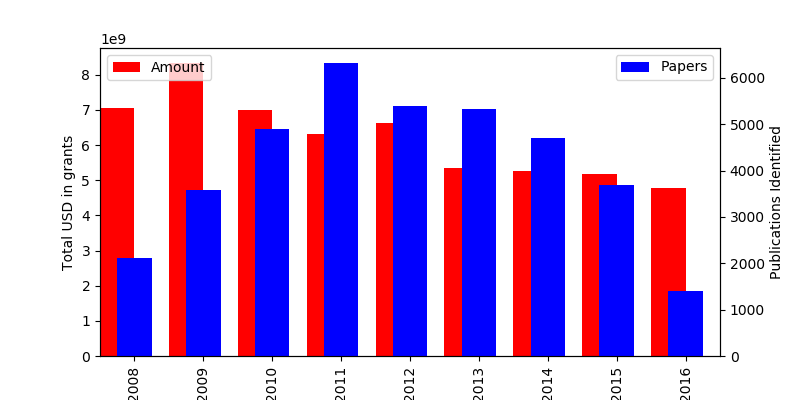

In [4]:
fig1 = plt.figure(1, figsize = (8,4))
ax = fig1.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx()
#sns.barplot(x = byyearA.index, y = byyearA.values, ax = ax)
#sns.barplot(x = byyearP.index, y = byyearP.values, ax = ax2)
byyear.Amount.plot(kind='bar', color='red', ax=ax, width=0.5, position=1)
byyear.Papers_funded.plot(kind='bar', color='blue', ax=ax2, width=0.5, position=0.5)
ax.set_ylabel('Total USD in grants')
ax2.set_ylabel('Publications Identified')
ax.legend(['Amount'], loc = 2)
ax2.legend(['Papers'], loc = 1)

In [6]:
#df = df.assign(Grant_Length=None)
grlength = (pd.to_datetime(df.End_Date) - pd.to_datetime(df.Date) )
grdays = grlength.astype('timedelta64[D]')

In [7]:
df = df.assign(Grant_Length=grdays.astype(int))

<IPython.core.display.Javascript object>


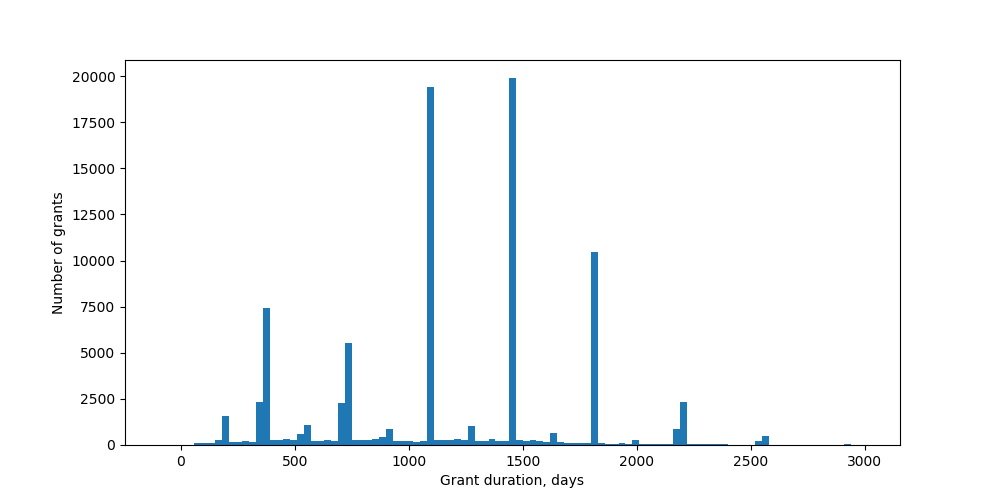

C:\Users\artem\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



Text(0,0.5,'Number of grants')

In [8]:
bins = np.array(list(range(-3,101) )) * 30
plt.figure(figsize = (10,5))
plt.hist(df.Grant_Length, bins=bins);
ax = plt.axes()
ax.set_xlabel('Grant duration, days')
ax.set_ylabel('Number of grants')

## Concentrating on the 2009-2015 period 

In [5]:
#load the data
df = pd.read_pickle('NSFdata2009-2015full')

with open('NSFcrossref2009-2015', 'rb') as handle:
    ad = pickle.load(handle)

### Overall correlation between grant amount and number of publications aknowledging it is very low

<IPython.core.display.Javascript object>


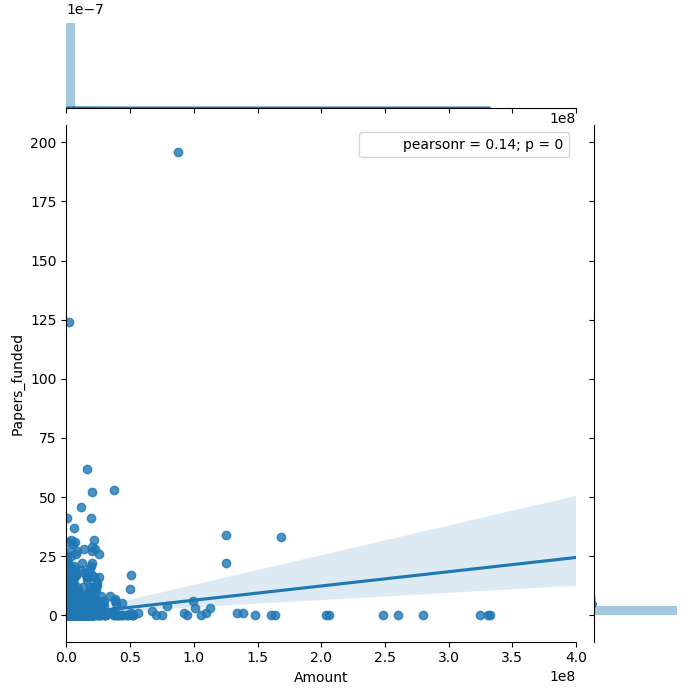

In [9]:
sns.jointplot(x="Amount", y="Papers_funded", data=df, size=7, kind='reg', xlim=[0, 4e8])

## Where is the money going geographically?

In [10]:
bycountry = df.groupby('Institution_Country').Amount.sum()
bycountry.sort_values(ascending=False, inplace=True)

In [11]:
print( ' USA accounts for ', '{0:.2f}'.format(bycountry['United States']/bycountry.sum()*100),'% of total NSF grant spedning in 2009-2015') 

 USA accounts for  99.53 % of total NSF grant spedning in 2009-2015


### State level

In [12]:
bystate = df[df.Institution_Country == 'United States'].groupby('Institution_State').Amount.sum()
bystate.sort_values(inplace = True, ascending=False)

<IPython.core.display.Javascript object>


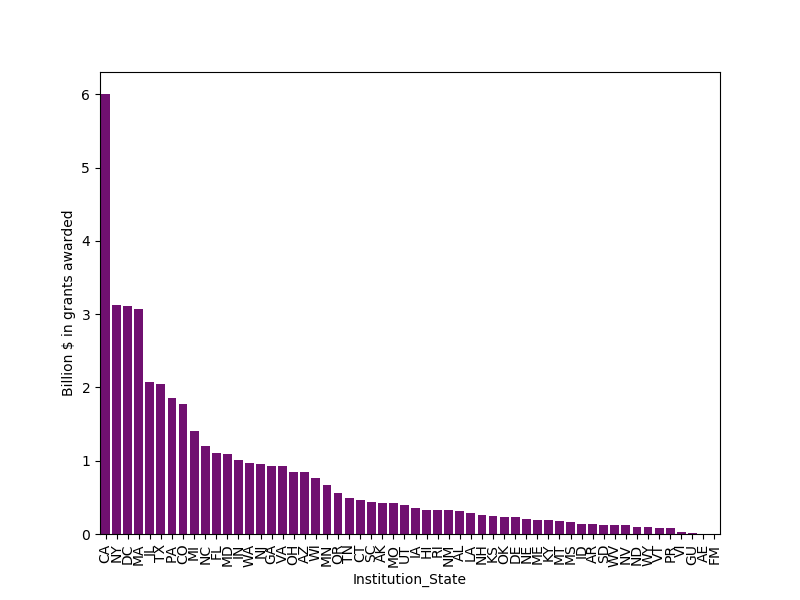

C:\Users\artem\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



In [13]:
fig101 = plt.figure(101, figsize = (8,6))
ax1 = sns.barplot(x = bystate.index, y = bystate.values, color='Purple')
for item in ax1.get_xticklabels():
    item.set_rotation(90)
ax1.set_ylabel('Billion $ in grants awarded')
ax1.set_yticklabels(['0', '1', '2', '3', '4', '5', '6']);

### State funding and publications over time 

In [14]:
byStateYear = pd.DataFrame(df.groupby(["Institution_State", "Year"]).sum()).reset_index()

<IPython.core.display.Javascript object>


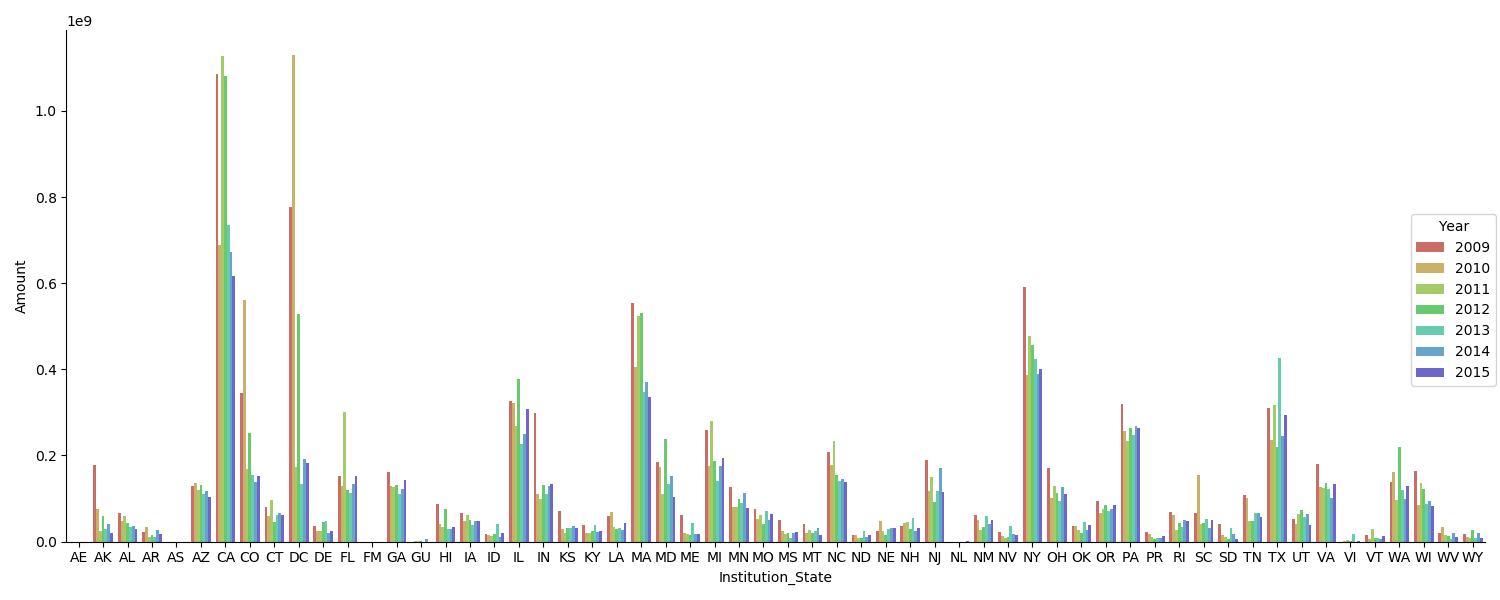

C:\Users\artem\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



In [15]:
g = sns.factorplot(x="Institution_State", y="Amount", hue="Year", data=byStateYear, kind="bar", palette=sns.color_palette("hls", 9), size = 6, aspect = 2.5, ci=None)

<IPython.core.display.Javascript object>


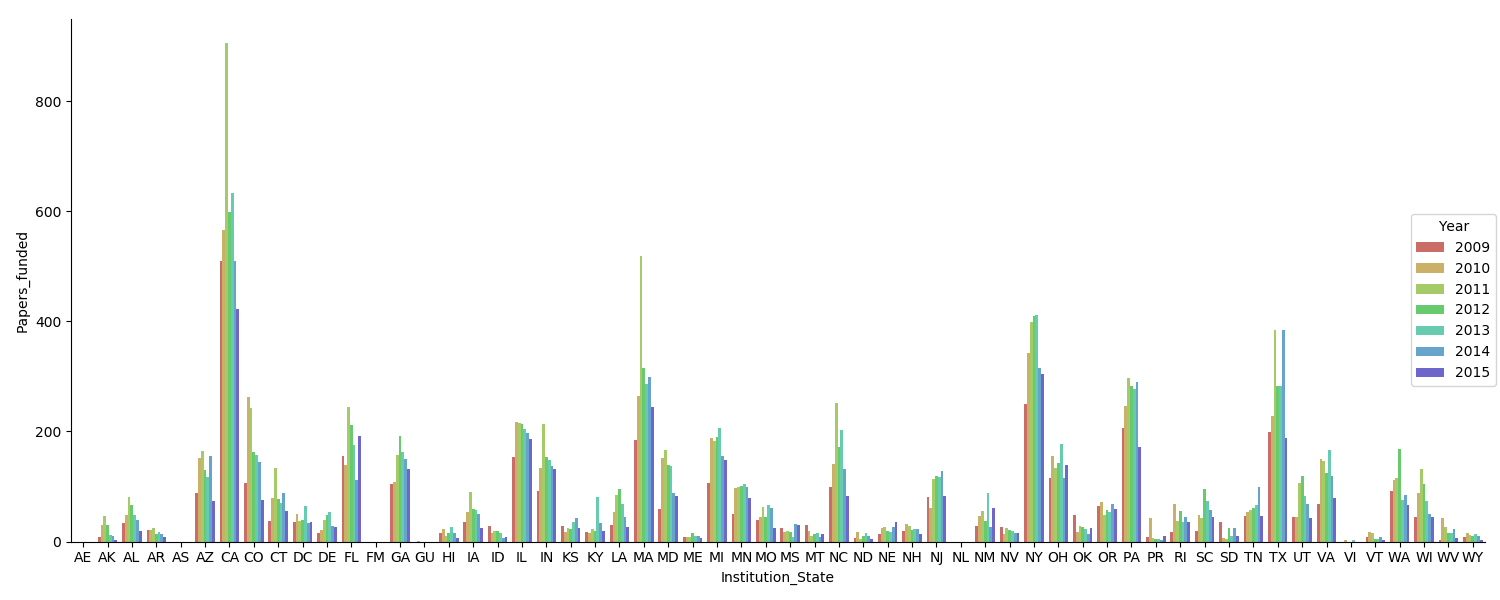

C:\Users\artem\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



In [16]:
g2 = sns.factorplot(x="Institution_State", y="Papers_funded", hue="Year", data=byStateYear, kind="bar", palette=sns.color_palette("hls", 9), size = 6, aspect = 2.5, ci=None)

### There is a significant correlation between total amount of grant money to a state per year and resulting number of publications

<IPython.core.display.Javascript object>


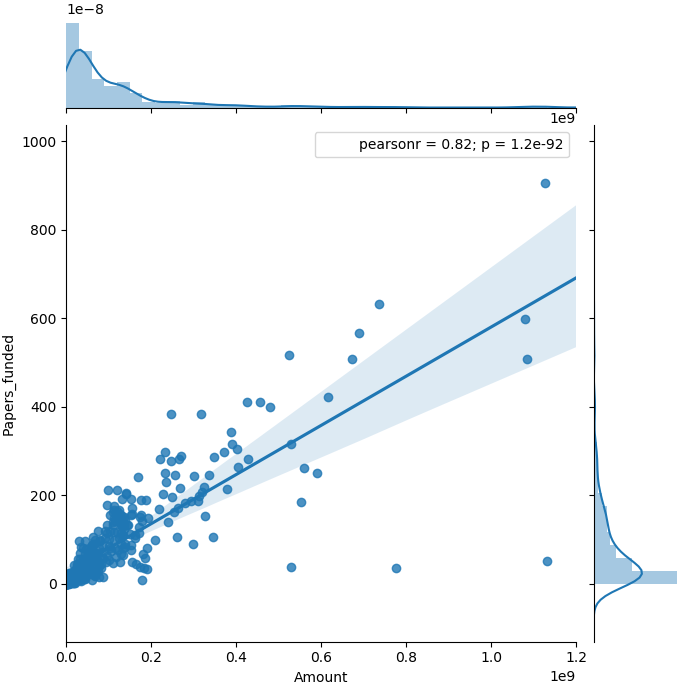

In [17]:
sns.jointplot(x="Amount", y="Papers_funded", data=byStateYear, size=7, kind='reg', xlim=[0, 1.2e9])

## Results for NSF directorates and divisions

### Data by directorate 

In [18]:
bydir = df.groupby('Directorate').sum().reset_index()
bydir.sort_values(by = 'Amount', inplace=True, ascending=False)

<IPython.core.display.Javascript object>


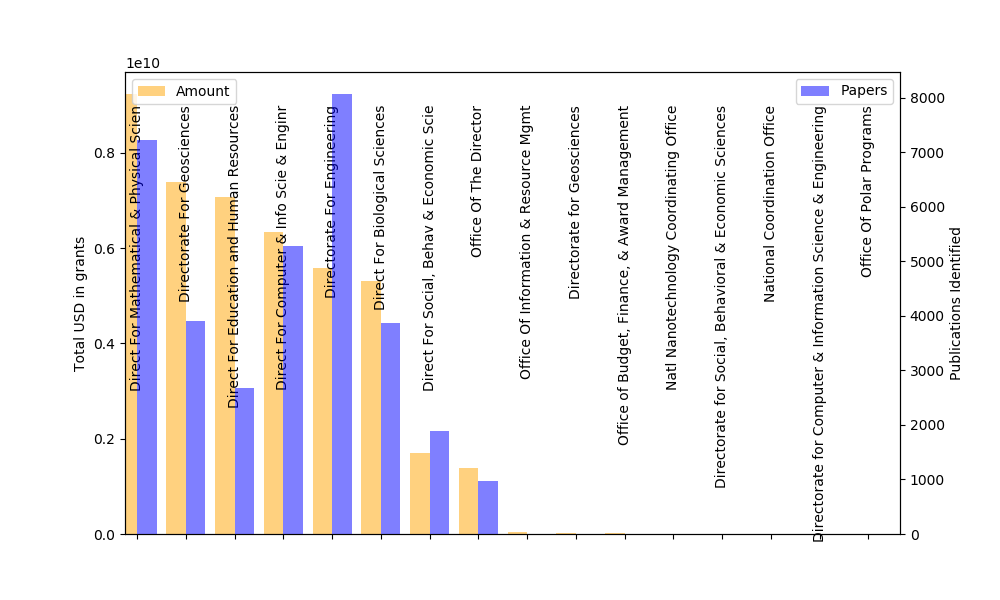

In [19]:
fig200 = plt.figure(200, figsize = (10,6))
ax = fig200.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx()
#sns.barplot(x = byyearA.index, y = byyearA.values, ax = ax)
#sns.barplot(x = byyearP.index, y = byyearP.values, ax = ax2)
bydir.Amount.plot(kind='bar', color='orange', ax=ax, width=0.4, position=1,  alpha=0.5)
bydir.Papers_funded.plot(kind='bar', color='blue', ax=ax2, width=0.4, position=0, alpha=0.5)
ax.set_ylabel('Total USD in grants')
ax2.set_ylabel('Publications Identified')
ax.legend(['Amount'], loc = 2)
ax2.legend(['Papers'], loc = 1)
ax.set_xticklabels(bydir.Directorate)
for item in ax.get_xticklabels():
    item.set_rotation(90)
    #item.set_verticalalignment('bottom')
    item.set_y(0.95)

### Cost per publications

In [20]:
bydir['Cost'] = bydir.Amount/bydir.Papers_funded
bydir.sort_values(by = 'Cost', inplace=True)

<IPython.core.display.Javascript object>


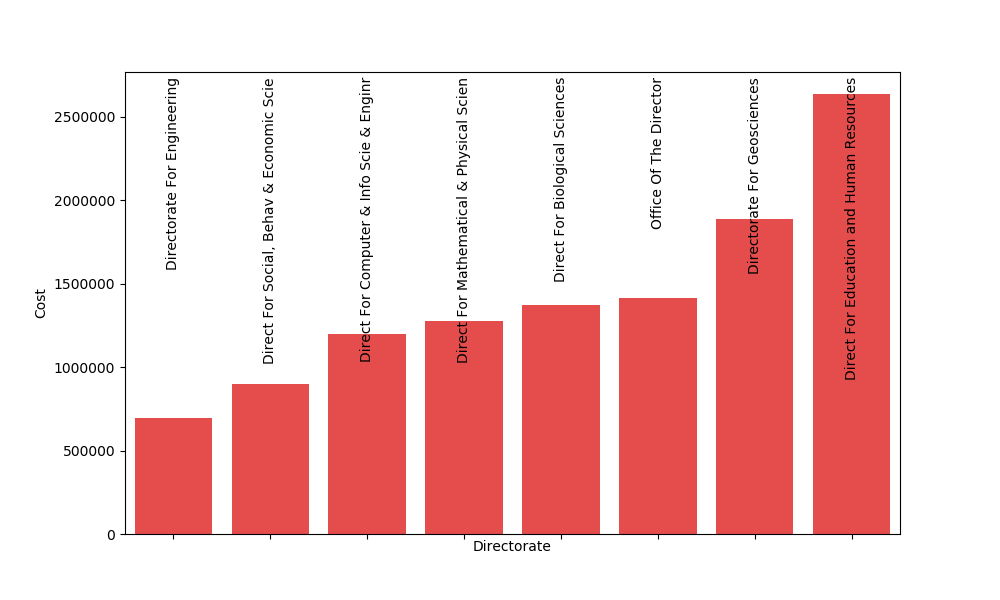

C:\Users\artem\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



In [21]:
fig201 = plt.figure(201, figsize = (10,6))
ax1 = sns.barplot(x = 'Directorate', y = 'Cost', data = bydir[bydir.Papers_funded > 1], color='Red', alpha=0.8)
for item in ax1.get_xticklabels():
    item.set_rotation(90)
    #item.set_verticalalignment('bottom')
    item.set_y(1.01)

### Division level

In [22]:
bydiv = df.groupby('Division').sum().reset_index()
bydiv.sort_values(by = 'Amount', inplace=True, ascending=False)

<IPython.core.display.Javascript object>


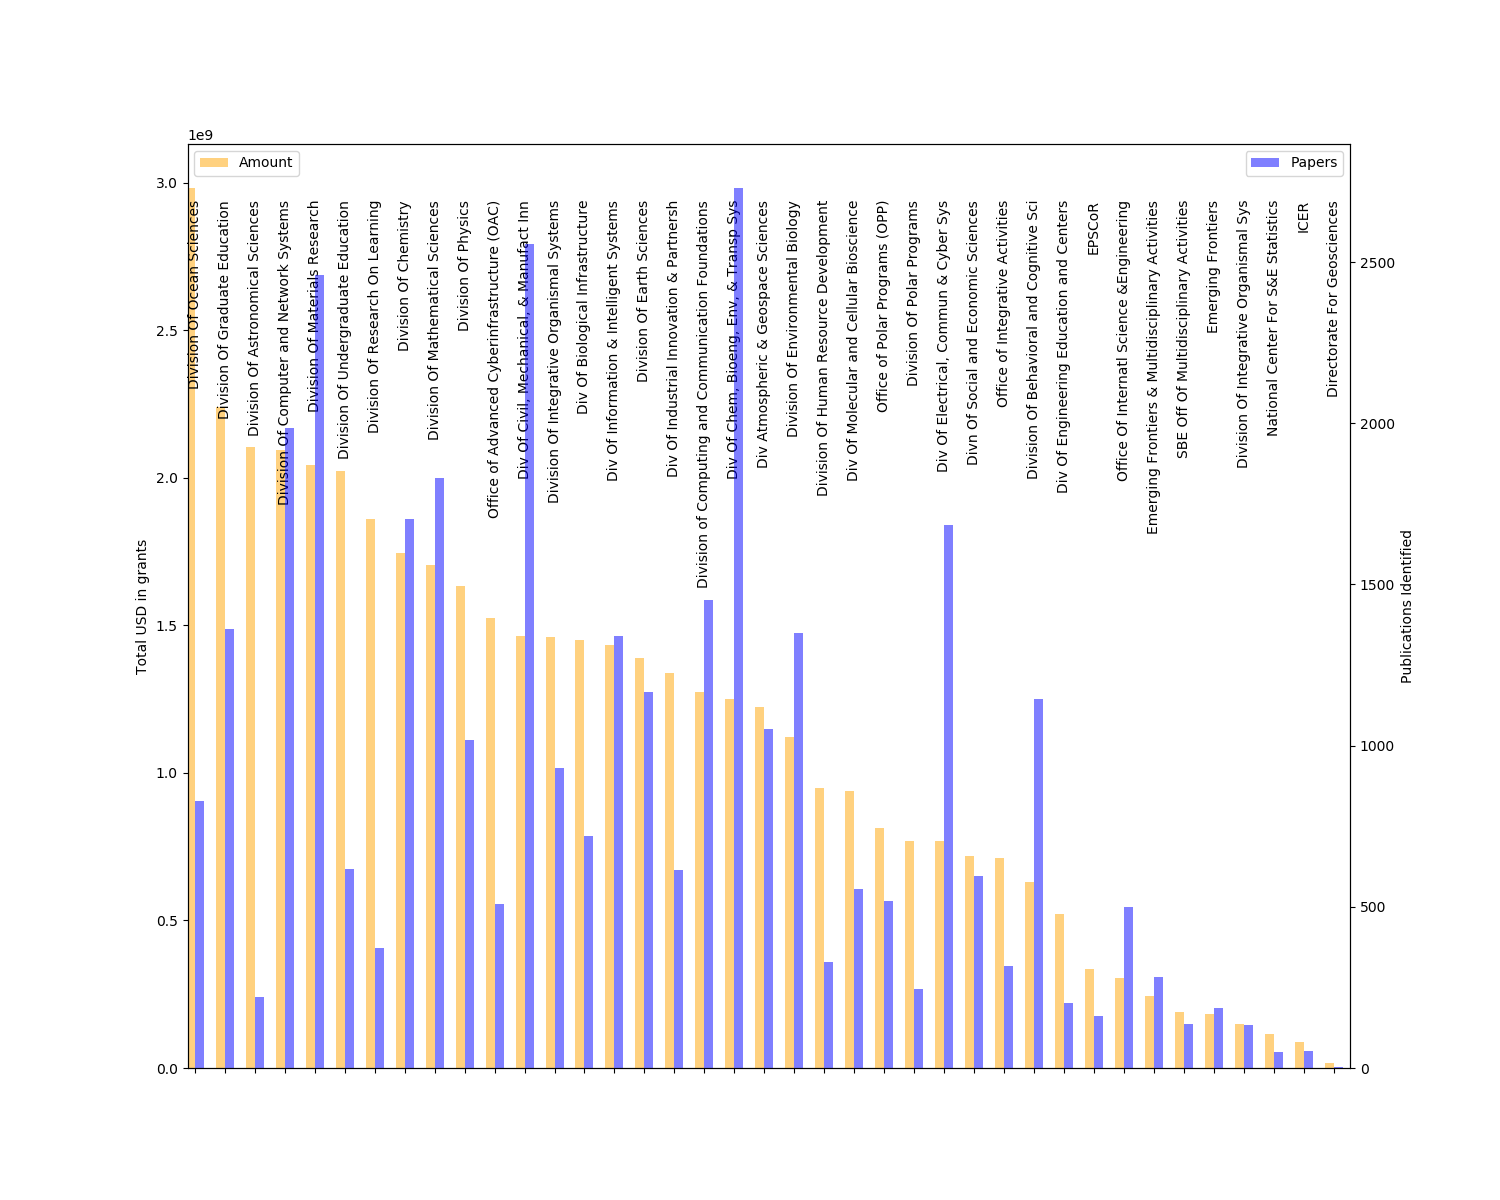

In [23]:
fig202 = plt.figure(202, figsize = (15,12))
ax = fig202.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx()
#sns.barplot(x = byyearA.index, y = byyearA.values, ax = ax)
#sns.barplot(x = byyearP.index, y = byyearP.values, ax = ax2)
bydiv[bydiv.Papers_funded > 2].Amount.plot(kind='bar', color='orange', ax=ax, width=0.3, position=1,  alpha=0.5)
bydiv[bydiv.Papers_funded > 2].Papers_funded.plot(kind='bar', color='blue', ax=ax2, width=0.3, position=0, alpha=0.5)
ax.set_ylabel('Total USD in grants')
ax2.set_ylabel('Publications Identified')
ax.legend(['Amount'], loc = 2)
ax2.legend(['Papers'], loc = 1)
ax.set_xticklabels(bydiv.Division)
for item in ax.get_xticklabels():
    item.set_rotation(90)
    #item.set_verticalalignment('bottom')
    item.set_y(0.95)

In [24]:
bydiv['Cost'] = bydiv.Amount/bydiv.Papers_funded
bydiv.sort_values(by = 'Cost', inplace=True)

<IPython.core.display.Javascript object>


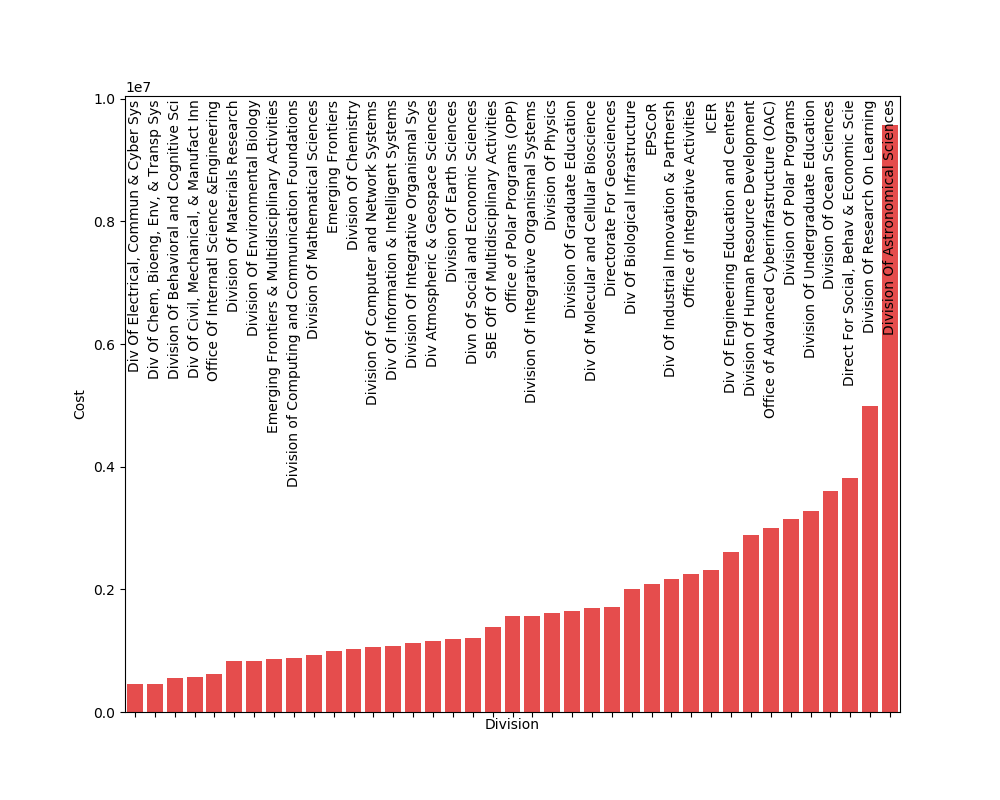

C:\Users\artem\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



In [25]:
fig203 = plt.figure(203, figsize = (10,8))
ax1 = sns.barplot(x = 'Division', y = 'Cost', data = bydiv[bydiv.Papers_funded > 2], color='Red', alpha = 0.8)
for item in ax1.get_xticklabels():
    item.set_rotation(90)
    #item.set_verticalalignment('bottom')
    item.set_y(1.01)

### Correlation between spending and publications in divisions

<IPython.core.display.Javascript object>


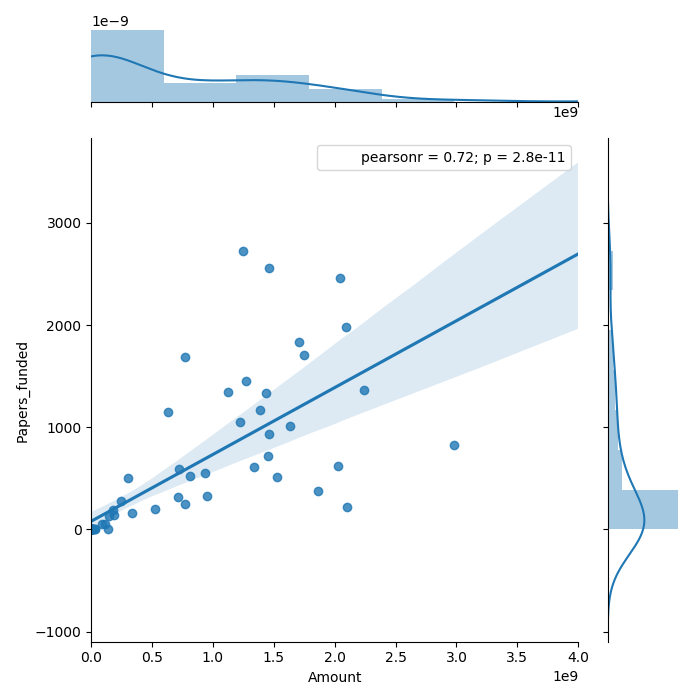

In [26]:
sns.jointplot(x="Amount", y="Papers_funded", data=bydiv, size=7, kind='reg', xlim=[0, 4e9], ratio = 5, space=0.1)
plt.tight_layout()